In [372]:
# Author Davide Aloi
# Motion tracking analysis
# Polhemus collects data at 60Hz so there's no need to filter. 
# Each trial file has a mat structure with 8 columns. Column 1 is the electrode number (1,2)
# column 2-3-4 are x, y and z respectively, and column 8 is the time. 

# The onsets of the move and relax trials are stored in the files active_onsets_move and 
# active_onsets_relax.mat. This also contains the duration of each stimulus

import numpy as np
import glob
import scipy.io

participant_path = "D:\\Raindrop_data\\p01\\"
baseline = 0.410 #ms
Hz = 60 # hz polhemus
# duration of the audios move / relax 
move_audio_d = 3.3578
relax_audio_d = 1.8166

# paths to motriontracking subfolders (baseline and day-4 (post))
mt_paths = glob.glob(participant_path + 'p*\\' + 'eeg_baseline\\active_task\\onsets*')
mt_paths_post = glob.glob(participant_path + 'p*\\day04_eeg\\active_task\\onsets*' + '')
mt_paths.append(mt_paths_post[0])
mt_paths.append(mt_paths_post[1])
mt_paths.append(mt_paths_post[2])

In [403]:
    # filtering functions
    import numpy as np
    from scipy.signal import butter, lfilter, freqz
    import matplotlib.pyplot as plt


    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

D:\Raindrop_data\p01\p01_w01\eeg_baseline\active_task\onsets_and_motiontracking
626


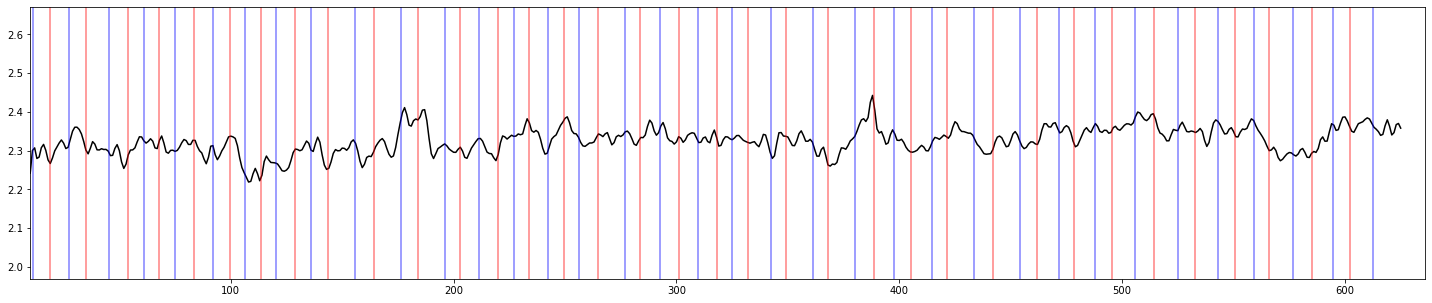

D:\Raindrop_data\p01\p01_w03\eeg_baseline\active_task\onsets_and_motiontracking
655


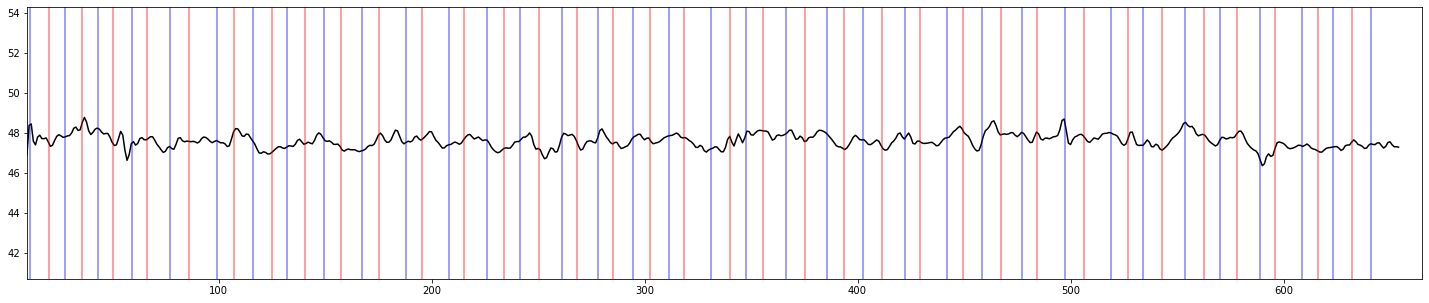

D:\Raindrop_data\p01\p01_w05\eeg_baseline\active_task\onsets_and_motiontracking
685


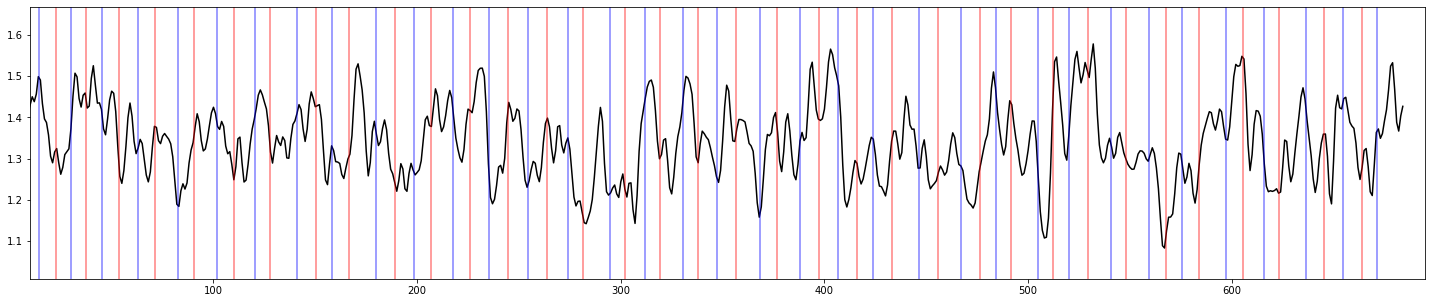

D:\Raindrop_data\p01\p01_w02\day04_eeg\active_task\onsets_and_motiontracking
626


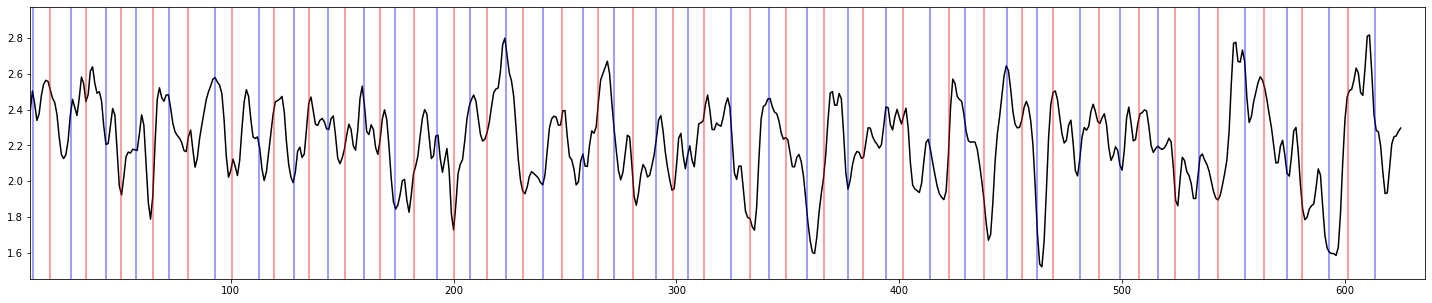

D:\Raindrop_data\p01\p01_w04\day04_eeg\active_task\onsets_and_motiontracking
596


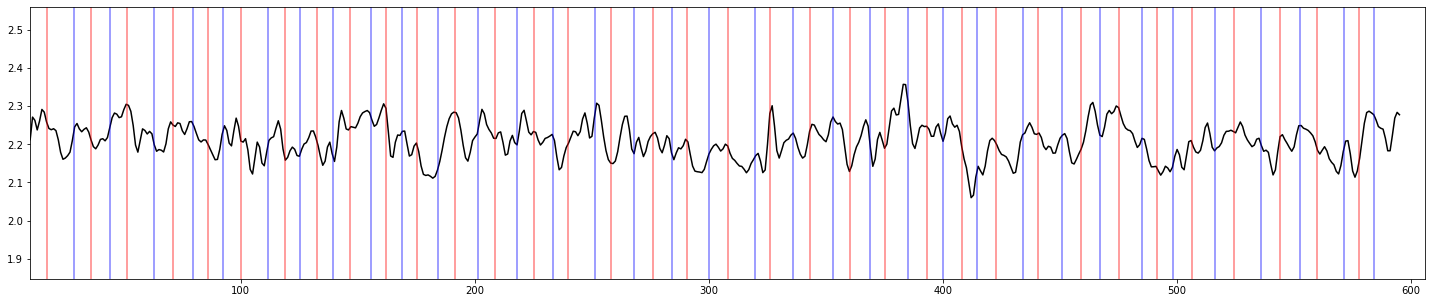

D:\Raindrop_data\p01\p01_w06\day04_eeg\active_task\onsets_and_motiontracking
655


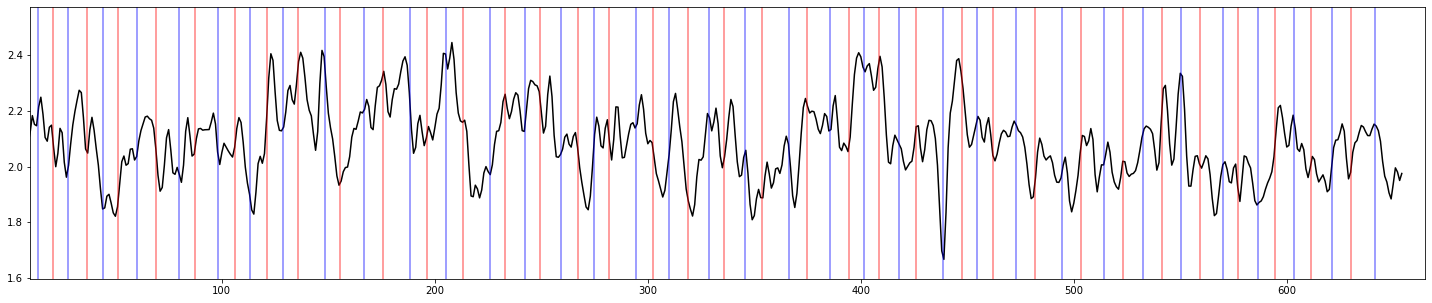

In [532]:
for path in mt_paths_baseline:
    print(path)

    # loading onsets amd durations (36 move 36 relax)
    onsets_move = scipy.io.loadmat(glob.glob(path + '\\*_move.mat')[0])
    onsets_relax = scipy.io.loadmat(glob.glob(path + '\\*_relax.mat')[0])

    # loading trials (and sorting them from 1 to 30)
    trials = glob.glob(path + '\\*trial*')
    trials_sorted = sorted(trials, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    all_durations_move = []
    all_durations_relax = []

    for onset_move in onsets_move['onsets_move']:   
        all_durations_move.append(onset_move[2][0][0])
    for onset_relax in onsets_relax['onsets_relax']:   
        all_durations_relax.append(onset_relax[2][0][0])

    # I'll create a temporal line with the onsets
    # 1 trial = baseline (0.410ms) + duration move + duration relax
    all_events_time = [0] # beginning 1st trial
    all_events_labels = ['start']

    for move, relax in zip(all_durations_move, all_durations_relax):
        all_events_labels.append('move')
        all_events_time.append(baseline + all_events_time[-1])

        all_events_labels.append('relax')
        all_events_time.append(all_events_time[-1] + move)

        all_events_labels.append('end relax')
        all_events_time.append(all_events_time[-1] + relax)

    # variables where we'll store the polhemus data
    x1, y1 , z1 = [], [], []
    x2, y2 , z2 = [], [], []

    # iterating each trial
    for trial in trials:
        trial_data = scipy.io.loadmat(trial)
        trial_data = trial_data['this_trial_movements_tosave']
        len_data = len(trial_data) # n data points
        
        # collecting data from electrode 1 
        elect1 = trial_data[np.arange(0, len_data, 2)]
        # collecting data from electrode 2 
        elect2 = trial_data[np.arange(1, len_data, 2)]

        # we'll store the data in 8 arrays for practicality
        for datapoint in elect1:
            x1.append(datapoint[1][0][0])
            y1.append(datapoint[2][0][0])
            z1.append(datapoint[3][0][0])

        # at the end of each trial there was a 0.100 ms gap before starting the next trial
        # so I want to add some empty values 
        x1.extend([0,0,0,0,0,0])
        y1.extend([0,0,0,0,0,0])
        z1.extend([0,0,0,0,0,0])

        for datapoint in elect2:
            x2.append(datapoint[1][0][0])
            y2.append(datapoint[2][0][0])
            z2.append(datapoint[3][0][0])

        x2.extend([0,0,0,0,0,0])
        y2.extend([0,0,0,0,0,0])
        z2.extend([0,0,0,0,0,0])

    ## Now that we have both the onset times, the onset labels and the x,y,z data
    # we can calculate the euclidean distance and plot the session
    # sometimes one electrode collects more data points than the other 
    
    if len(x1) > len(x2):
        l = len(x2)
        x1, y1, z1 = x1[0:l], y1[0:l], z1[0:l]
    else:
        l = len(x1)
        x2, y2, z2 = x2[0:l], y2[0:l], z2[0:l]
    
    # calculating euclidean distance
    from scipy.spatial import distance
    e_u = []
    for n in range(0, len(x1)):
        if (x1[n] + y1[n] + z1[n]) != 0:
            if (x2[n] + y2[n] + z2[n]) != 0:
               dst = distance.euclidean((x1[n], y1[n], z1[n]), (x2[n], y2[n], z2[n]))
        else:
            dst = np.nan
        e_u.append(dst)

    e_u = np.asarray(e_u)
    #e_u = np.where(e_u > np.nanmean(e_u)+1, np.nanmean(e_u), e_u)

    filter_hz = 15
    e_u = butter_lowpass_filter(e_u, filter_hz, Hz, 5)

    # calculating 
    import matplotlib.pyplot as plt
    fix, ax = plt.subplots(figsize = (25,5))

    ax.plot(np.arange(0,len(e_u)), e_u, color = 'black')
    not_nans = np.count_nonzero(~np.isnan(e_u))
    scale_factor = len(e_u) / not_nans
    print(not_nans)
    for event_time, label in zip(np.asarray(all_events_time)*Hz, all_events_labels):
        if label == 'move':
            ax.axvline(x = event_time/scale_factor, color = 'red', alpha = 0.5)
        if label == 'relax':
           ax.axvline(x = event_time/scale_factor, color = 'blue', alpha = 0.5)
    
    plt.xlim(10, not_nans+10)
    plt.ylim(np.nanmean(e_u)-np.nanstd(e_u)*3, np.nanmean(e_u)+np.nanstd(e_u)*3)
    plt.show()